# Load and unzip from colad

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
train_path = "/content/drive/MyDrive/Colab Notebooks/data-collection-homeworks/train"
test_path = "/content/drive/MyDrive/Colab Notebooks/data-collection-homeworks/test"

<h1>Import Libraries üß∞</a></h1>

In [20]:
# data processing, CSV & image file I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

<h1>Data Loading üíæ</h1><a/>

In [21]:
labels= ['PNEUMONIA','NORMAL']

In [22]:
def get_file_sizes(directory):
    file_sizes = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            size = os.path.getsize(file_path) / 1024 #bytes to KB
            file_sizes.append({'file': file_path, 'size_kb': round(size,3)})
    return file_sizes

In [23]:
def create_dataframe(path=None, labels=None):
    data = []
    for label in labels:
        category_path = os.path.join(path, label)
        file_sizes = get_file_sizes(category_path)
        data.extend(file_sizes)

    df = pd.DataFrame(data)
    return df

In [24]:
train_df = create_dataframe(train_path, labels)
test_df = create_dataframe(test_path, labels)

print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)

shape of train_dir (5233, 2)
shape of test_dir (624, 2)


In [25]:
train_df.head(3)

file  size_kb
0  /content/drive/MyDrive/Colab Notebooks/data-co...  428.794
1  /content/drive/MyDrive/Colab Notebooks/data-co...  655.636
2  /content/drive/MyDrive/Colab Notebooks/data-co...  525.493

In [26]:
def extract_label(file_path):
    if 'PNEUMONIA' in file_path:
        return 'pneumonia'
    elif 'NORMAL' in file_path:
        return 'normal'
    else:
        return 'unknown'

dict_dir_df = {'train': train_df,
               'test': test_df}

In [27]:
for df in dict_dir_df.values():
    df['label'] = df['file'].apply(extract_label)

In [28]:
train_df.sample(3)

file  size_kb      label
2680  /content/drive/MyDrive/Colab Notebooks/data-co...  431.762  pneumonia
1920  /content/drive/MyDrive/Colab Notebooks/data-co...  563.515  pneumonia
1050  /content/drive/MyDrive/Colab Notebooks/data-co...  758.017  pneumonia

In [29]:
def get_image_dimensions(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        return (0, 0)

In [30]:
for name, df in dict_dir_df.items():
    df['dimensions'] = df['file'].apply(get_image_dimensions)

Error reading image /content/drive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA/.DS_Store: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA/.DS_Store'


In [31]:
for name, df in dict_dir_df.items():
    filtered_dir = df[df['dimensions'].apply(lambda x: len(x) >= 3)]
    print(f'{name}:',filtered_dir.shape[0])

train: 0
test: 0


In [32]:
train_df.sample(3)

file  size_kb      label  \
2364  /content/drive/MyDrive/Colab Notebooks/data-co...  341.414  pneumonia   
1210  /content/drive/MyDrive/Colab Notebooks/data-co...  181.503  pneumonia   
2960  /content/drive/MyDrive/Colab Notebooks/data-co...  538.303  pneumonia   

       dimensions  
2364  (1064, 592)  
1210   (440, 760)  
2960  (1160, 856)

# Exploratory Data Analysis (EDA)

In [36]:
def create_bar_chart(data_frame):
    return go.Figure(go.Bar(
        x=data_frame['label'].value_counts().index,
        y=data_frame['label'].value_counts().values,
        marker_color=['#66c2a5', '#fc8d62']
    ))

def create_pie_chart(data_frame):
    return go.Figure(go.Pie(
        labels=data_frame['label'].value_counts().index,
        values=data_frame['label'].value_counts().values,
        marker=dict(
            colors=['#66c2a5', '#fc8d62'],
            line=dict(color='gray', width=3)),
        pull=[0.05, 0]
    ))

def configure_layout():
    return dict(
        showlegend=False,
        title='Distribution of Diagnosis on Training Set',
        title_x=0.5,
        shapes=[dict(type='line', x0=0.5, y0=0, x1=0.5, y1=1, line=dict(color='#000000', width=2))]
    )

def display_figure(fig):
    fig.show()

def main():
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'xy'}, {'type': 'domain'}]])

    bar_chart = create_bar_chart(train_df)
    pie_chart = create_pie_chart(train_df)

    fig.add_trace(bar_chart['data'][0], row=1, col=1)
    fig.add_trace(pie_chart['data'][0], row=1, col=2)

    fig.update_layout(**configure_layout())
    display_figure(fig)

main()

In [37]:
def calculate_average_dimensions(data_frame):
    height_mean = np.mean(data_frame['dimensions'].apply(lambda x: x[0]))
    width_mean = np.mean(data_frame['dimensions'].apply(lambda x: x[1]))
    return height_mean, width_mean

def display_average_dimensions(height_mean, width_mean):
    print(f"The average height of the images is {height_mean:.2f} pixels")
    print(f"The average width of the images is {width_mean:.2f} pixels")

def main():
    height_mean, width_mean = calculate_average_dimensions(train_df)
    display_average_dimensions(height_mean, width_mean)

main()

The average height of the images is 1175.14 pixels
The average width of the images is 1123.26 pixels


In [38]:
def find_minimum_file_sizes(data_frames):
    for name, df in data_frames.items():
        min_size = df['size_kb'].min()
        print(f"Minimum file size in {name}: {min_size}")

def main():
    dict_dir_df = {'train': train_df, 'test': test_df}
    find_minimum_file_sizes(dict_dir_df)

main()

Minimum file size in train: 19.205
Minimum file size in test: 31.19


In [39]:
max_file_sizes = {name: df['size_kb'].max() for name, df in dict_dir_df.items()}

for name, max_size in max_file_sizes.items():
    print(f"Maximum file size in {name}: {max_size} KB")

Maximum file size in train: 4087.972 KB
Maximum file size in test: 706.865 KB


In [46]:
import plotly.express as px

# Extract dimensions efficiently
dimensions = train_df['dimensions'].tolist()
heights, widths = zip(*dimensions)

fig = px.box(
    x=['Height']*len(heights) + ['Width']*len(widths),
    y=list(heights) + list(widths),
    labels={'x': 'Dimension Type', 'y': 'Pixels'},
    points='outliers',
    title="Boxplot of Image Dimensions (Height and Width)",
    color_discrete_sequence=['royalblue', 'darkorange']
)

fig.update_traces(marker_line_width=2, opacity=0.8)

fig.show()

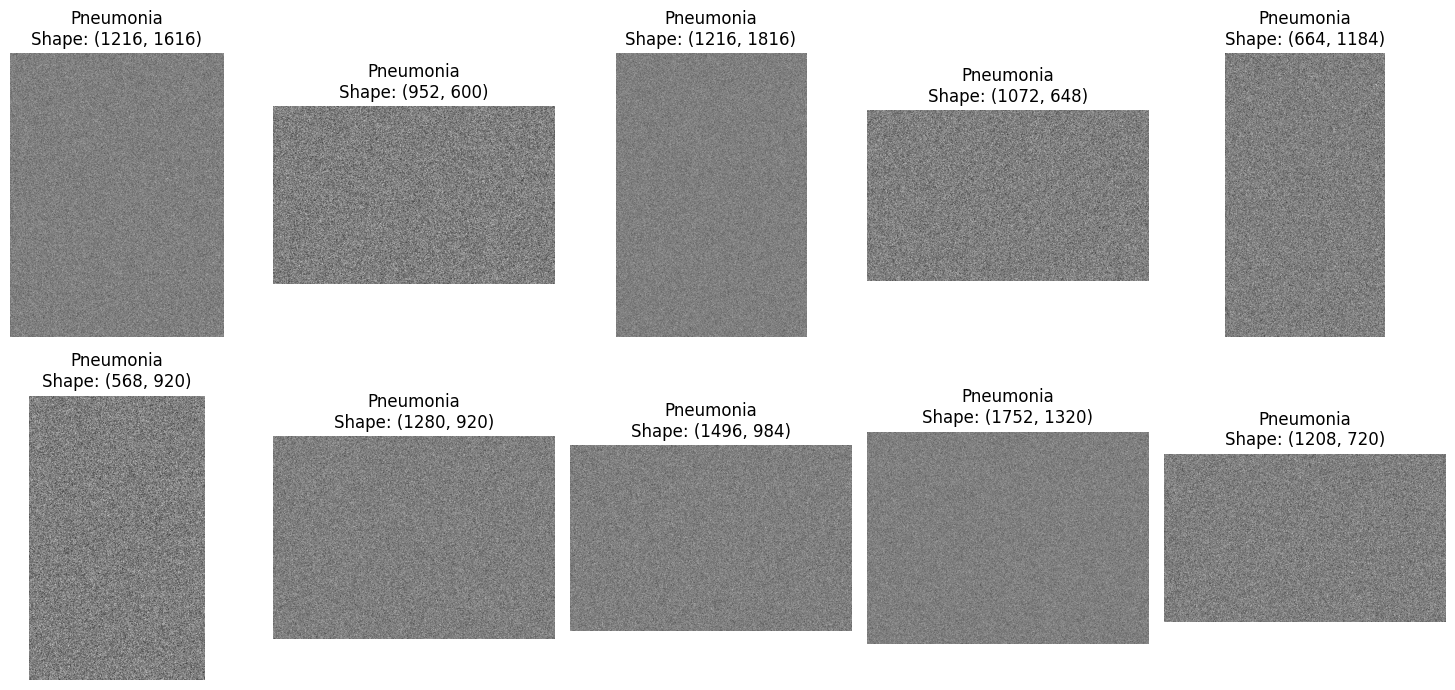

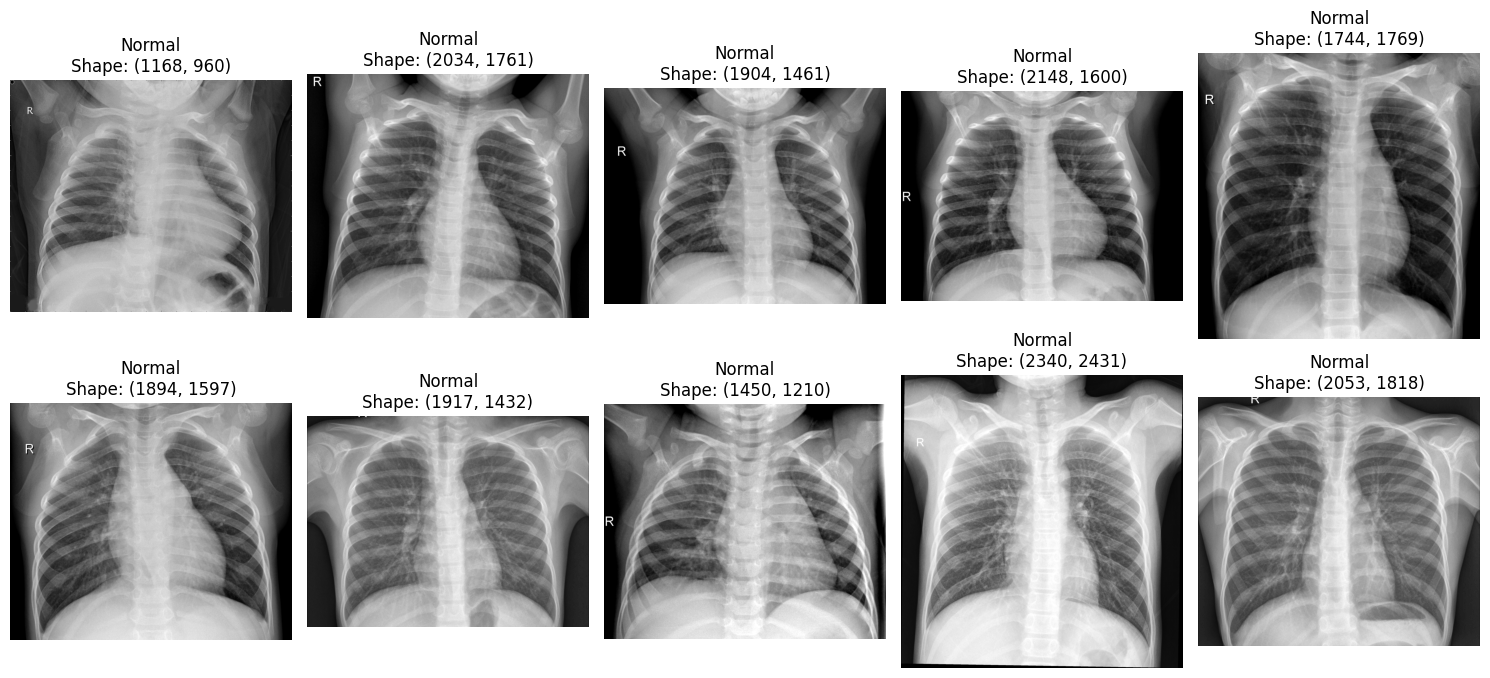

In [50]:
def plot_images(image_paths, label, nrows=2, ncols=5, figsize=(15, 7)):
    """Plots a grid of images with labels and shape information."""

    num_images = nrows * ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for i, image_path in enumerate(image_paths[:num_images]):
        row_idx, col_idx = divmod(i, ncols)
        with Image.open(image_path) as img:
            axes[row_idx, col_idx].imshow(img, cmap='gray')
            axes[row_idx, col_idx].axis('off')
            axes[row_idx, col_idx].set_title(f'{label}\nShape: {img.size}')

    plt.tight_layout()
    plt.show()

pneumonia_paths = train_df.query("label=='pneumonia'")['file'].values
normal_paths = train_df.query("label=='normal'")['file'].values

plot_images(pneumonia_paths, label='Pneumonia')
plot_images(normal_paths, label='Normal')

In [51]:
filtered_pneumonia_path = train_df.query("label=='pneumonia' and size_kb < 10")['file'].values
filtered_normal_path = train_df.query("label=='normal' and size_kb < 10")['file'].values

print(len(filtered_pneumonia_path))
print(len(filtered_normal_path))

0
0


In [45]:
filtered_pneumonia_test = test_df.query("label=='pneumonia' and size_kb < 10")['file'].values
filtered_normal_test = test_df.query("label=='normal' and size_kb < 10")['file'].values

print(len(filtered_pneumonia_test))
print(len(filtered_normal_test))

0
0


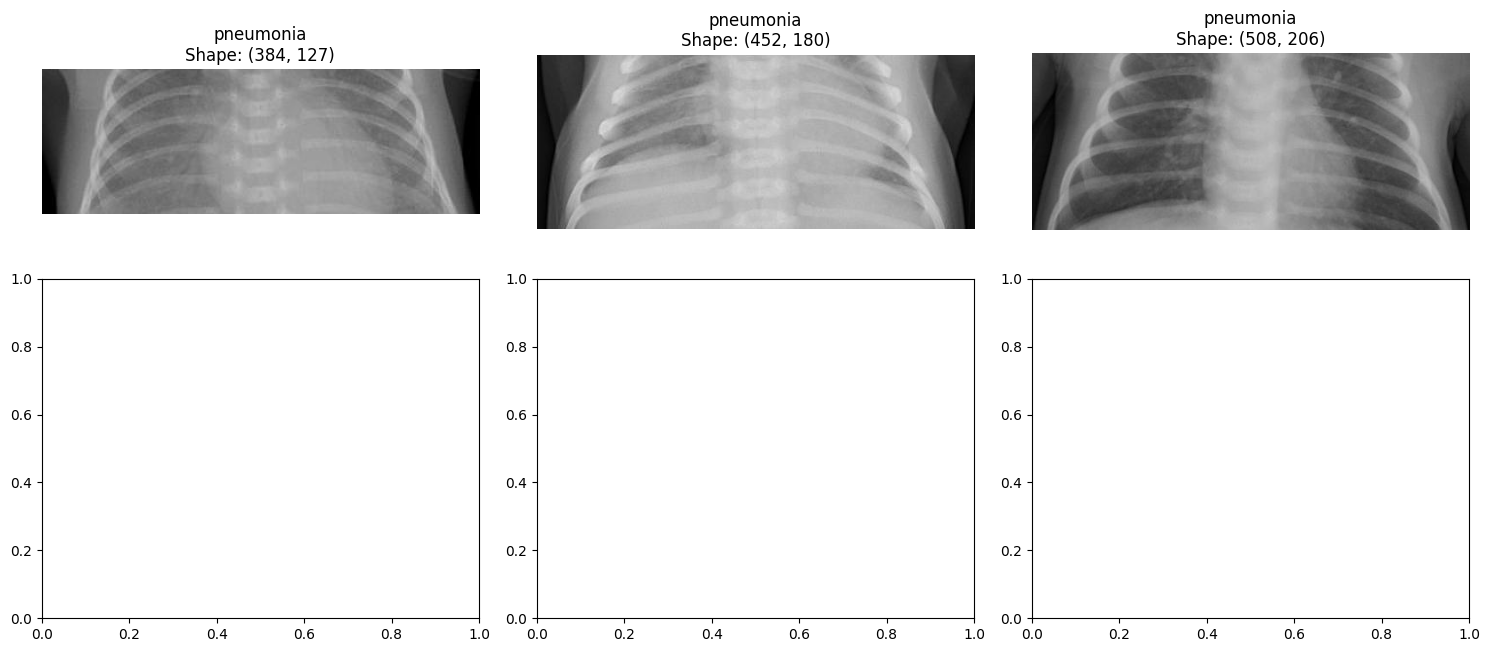

In [ ]:
plot_images(filtered_pneumonia_test, 'pneumonia', nrows=2, ncols=3)

In [ ]:
pneumonia_path = train_df.query("label=='pneumonia'")['file'].values
normal_path = train_df.query("label=='normal'")['file'].values

In [ ]:
pneumonia_path

array(['/content/gdrive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA/person1203_bacteria_3155.jpeg',
       '/content/gdrive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA/person1301_virus_2241.jpeg',
       '/content/gdrive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA/person89_virus_168.jpeg',
       ...,
       '/content/gdrive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA/person1463_bacteria_3809.jpeg',
       '/content/gdrive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA/person1284_bacteria_3247.jpeg',
       '/content/gdrive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA/person1121_virus_1846.jpeg'],
      dtype=object)

In [ ]:
tf.strings.split('/content/gdrive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA/person1203_bacteria_3155.jpeg',
                 os.path.sep)

<tf.Tensor: shape=(9,), dtype=string, numpy=
array([b'', b'content', b'gdrive', b'MyDrive', b'Colab Notebooks',
       b'data-collection-homeworks', b'train', b'PNEUMONIA',
       b'person1203_bacteria_3155.jpeg'], dtype=object)>

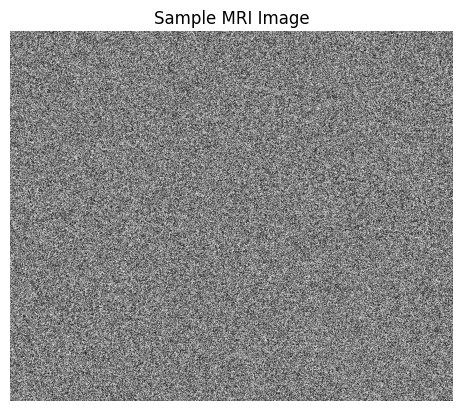

In [ ]:
pneumonia_path = "/content/gdrive/MyDrive/Colab Notebooks/data-collection-homeworks/train/PNEUMONIA"

image_files = [f for f in os.listdir(pneumonia_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

num_samples = len(image_files)
data = {
    'Patient_ID': [f'Patient_{i}' for i in range(num_samples)],
    'Age': np.random.randint(20, 80, size=num_samples),
    'Gender': np.random.choice(['Male', 'Female'], size=num_samples),
    'Imaging_Type': np.random.choice(['X-ray', 'MRI', 'CT'], size=num_samples),
}

df = pd.DataFrame(data)

df['Image_Path'] = np.random.choice(image_files, size=num_samples)
df['Image_Path'] = df['Image_Path'].apply(lambda x: os.path.join(pneumonia_path, x))

for index, row in df.iterrows():
    image_path = row['Image_Path']
    img = Image.open(image_path)

    image_data = np.random.rand(*img.size) * 255
    Image.fromarray(image_data.astype('uint8')).save(image_path)

sample_image_path = df.loc[0, 'Image_Path']
sample_image = Image.open(sample_image_path)

plt.imshow(sample_image, cmap='gray')
plt.title(f"Sample {df.loc[0, 'Imaging_Type']} Image")
plt.axis('off')
plt.show()

csv_path = 'patients_with_pneuminia.csv'
df.to_csv(csv_path, index=False)

–°–≤—è–∑–∫–∞ –º—É–ª—å—Ç–∏–º–æ–¥–µ–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –æ–±–æ–∑–Ω–∞—á–∞–µ—Ç –∏–Ω—Ç–µ–≥—Ä–∞—Ü–∏—é –∏ –∞–Ω–∞–ª–∏–∑ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏, –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–Ω–æ–π –≤ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –º–æ–¥–∞–ª—å–Ω–æ—Å—Ç—è—Ö –∏–ª–∏ —Ñ–æ—Ä–º–∞—Ç–∞—Ö. –í —ç—Ç–æ–º –∫–æ–Ω—Ç–µ–∫—Å—Ç–µ, –º–æ–¥–∞–ª—å–Ω–æ—Å—Ç–∏ –º–æ–≥—É—Ç –≤–∫–ª—é—á–∞—Ç—å —Ç–µ–∫—Å—Ç, –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è, –∑–≤—É–∫, –≤–∏–¥–µ–æ –∏ –¥—Ä—É–≥–∏–µ –≤–∏–¥—ã –¥–∞–Ω–Ω—ã—Ö. –ü—Ä–∏–Ω—Ü–∏–ø —Å–≤—è–∑–∫–∏ –∑–∞–∫–ª—é—á–∞–µ—Ç—Å—è –≤ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏–∏ –º–Ω–æ–≥–æ–º–æ–¥–∞–ª—å–Ω—ã—Ö –∏—Å—Ç–æ—á–Ω–∏–∫–æ–≤ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –±–æ–ª–µ–µ –ø–æ–ª–Ω–æ–≥–æ –∏ –∫–æ–º–ø–ª–µ–∫—Å–Ω–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏. –≠—Ç–æ –ø–æ–∑–≤–æ–ª—è–µ—Ç –≤—ã—è–≤–ª—è—Ç—å –≤–∑–∞–∏–º–æ—Å–≤—è–∑–∏ –∏ –ø–∞—Ç—Ç–µ—Ä–Ω—ã –º–µ–∂–¥—É —Ä–∞–∑–ª–∏—á–Ω—ã–º–∏ –º–æ–¥–∞–ª—å–Ω–æ—Å—Ç—è–º–∏, —É–ª—É—á—à–∞—è –ø–æ–Ω–∏–º–∞–Ω–∏–µ –∏ –æ–±–æ–≥–∞—â–µ–Ω–∏–µ –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞. –¢–∞–∫–æ–π –ø–æ–¥—Ö–æ–¥ —à–∏—Ä–æ–∫–æ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –≤ –æ–±–ª–∞—Å—Ç—è—Ö –∏—Å–∫—É—Å—Å—Ç–≤–µ–Ω–Ω–æ–≥–æ –∏–Ω—Ç–µ–ª–ª–µ–∫—Ç–∞, –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è –∏ –∞–Ω–∞–ª–∏–∑–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –±–æ–ª–µ–µ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ–≥–æ —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á, —Ç–∞–∫–∏—Ö –∫–∞–∫ —Ä–∞—Å–ø–æ–∑–Ω–∞–≤–∞–Ω–∏–µ –æ–±—Ä–∞–∑–æ–≤, –æ–±—Ä–∞–±–æ—Ç–∫–∞ —è–∑—ã–∫–∞ –∏ –º–Ω–æ–≥–∏–µ –¥—Ä—É–≥–∏–µ.

–ú—É–ª—å—Ç–∏–º–æ–¥–∞–ª—å–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –º–æ–≥—É—Ç –±—ã—Ç—å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω—ã –≤ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –æ–±–ª–∞—Å—Ç—è—Ö, –∏ –∏—Ö –ø—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –∑–∞–≤–∏—Å–∏—Ç –æ—Ç –∫–æ–Ω–∫—Ä–µ—Ç–Ω–æ–≥–æ –∫–æ–Ω—Ç–µ–∫—Å—Ç–∞ –∏ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö. –í–æ—Ç –Ω–µ—Å–∫–æ–ª—å–∫–æ –≤–æ–∑–º–æ–∂–Ω—ã—Ö –∫–µ–π—Å–æ–≤ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –º—É–ª—å—Ç–∏–º–æ–¥–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:

1. **–ú–µ–¥–∏—Ü–∏–Ω—Å–∫–∞—è –¥–∏–∞–≥–Ω–æ—Å—Ç–∏–∫–∞:**
   - **–ö–µ–π—Å:** –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –∏–∑ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –º–µ–¥–∏—Ü–∏–Ω—Å–∫–∏—Ö –æ–±—Ä–∞–∑–æ–≤–∞—Ç–µ–ª—å–Ω—ã—Ö –º–æ–¥–∞–ª—å–Ω–æ—Å—Ç–µ–π (–Ω–∞–ø—Ä–∏–º–µ—Ä, –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π —Å–Ω–∏–º–∫–æ–≤, —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –∞–Ω–∞–ª–∏–∑–æ–≤, —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö –æ–ø–∏—Å–∞–Ω–∏–π –±–æ–ª–µ–∑–Ω–µ–π).
   - **–ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ:** –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –º—É–ª—å—Ç–∏–º–æ–¥–∞–ª—å–Ω–æ–π –º–æ–¥–µ–ª–∏ –¥–ª—è –¥–∏–∞–≥–Ω–æ—Å—Ç–∏–∫–∏ –±–æ–ª–µ–∑–Ω–µ–π —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –∏–∑ —Ä–∞–∑–Ω—ã—Ö –∏—Å—Ç–æ—á–Ω–∏–∫–æ–≤.

2. **–°–∏—Å—Ç–µ–º—ã –≤–∏–¥–µ–æ–Ω–∞–±–ª—é–¥–µ–Ω–∏—è:**
   - **–ö–µ–π—Å:** –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –∏–∑ –≤–∏–¥–µ–æ- –∏ –∞—É–¥–∏–æ—Å–∏—Å—Ç–µ–º –¥–ª—è –±–æ–ª–µ–µ —Ç–æ—á–Ω–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞ –ø–æ–≤–µ–¥–µ–Ω–∏—è –∏ —Å–∏—Ç—É–∞—Ü–∏–π.
   - **–ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ:** –†–∞–∑—Ä–∞–±–æ—Ç–∫–∞ —Å–∏—Å—Ç–µ–º—ã –¥–ª—è –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–≥–æ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏—è –∏ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Å–æ–±—ã—Ç–∏–π, —Ç–∞–∫–∏—Ö –∫–∞–∫ –∏–Ω—Ü–∏–¥–µ–Ω—Ç—ã –Ω–∞ —É–ª–∏—Ü–µ, –Ω–∞ –æ—Å–Ω–æ–≤–µ –≤–∏–¥–µ–æ –∏ –∞—É–¥–∏–æ–¥–∞–Ω–Ω—ã—Ö.

3. **–°–æ—Ü–∏–∞–ª—å–Ω—ã–µ —Å–µ—Ç–∏ –∏ –∞–Ω–∞–ª–∏—Ç–∏–∫–∞:**
   - **–ö–µ–π—Å:** –°–≤—è–∑–∫–∞ —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö (–ø–æ—Å—Ç—ã, –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏) —Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º–∏ –ø—Ä–æ—Ñ–∏–ª–µ–π –≤ —Å–æ—Ü–∏–∞–ª—å–Ω—ã—Ö —Å–µ—Ç—è—Ö.
   - **–ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ:** –†–∞–∑—Ä–∞–±–æ—Ç–∫–∞ –º–æ–¥–µ–ª–∏ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏, –≤—ã—è–≤–ª–µ–Ω–∏—è —Ç–µ–º –∏ –ø–µ—Ä—Å–æ–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Ç–µ–∫—Å—Ç–æ–≤ –∏ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π.
